## [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo)

In [14]:
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [15]:
data_fpath = './data/names.txt'

In [16]:
with open(data_fpath, 'r') as f:
    words = f.read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [17]:
len(words)

32033

In [18]:
word_lens = [len(word) for word in words]
print(f'min len: {min(word_lens)}; max len: {max(word_lens)}')
# plt.hist(word_lens, bins=13)

min len: 2; max len: 15


In [19]:
SEP_TOK = '.'

In [20]:
bigrams_dict = {}
for word in words:
    chars = [SEP_TOK] + list(word) + [SEP_TOK]
    for bigram in zip(chars, chars[1:]):
        bigrams_dict[bigram] = bigrams_dict.get(bigram, 0) + 1
bigrams_dict = sorted(bigrams_dict.items(), key=lambda kv: kv[1], reverse=True)
bigrams_dict[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

In [21]:
vocab = [SEP_TOK] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}

## Bigram model as an array with counts

In [9]:
N = torch.zeros((len(vocab), len(vocab)), dtype=torch.int32)
for word in tqdm(words):
    chars = [SEP_TOK] + list(word) + [SEP_TOK]
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

  0%|          | 92/32033 [00:00<00:34, 914.98it/s]

100%|██████████| 32033/32033 [00:16<00:00, 1884.55it/s]


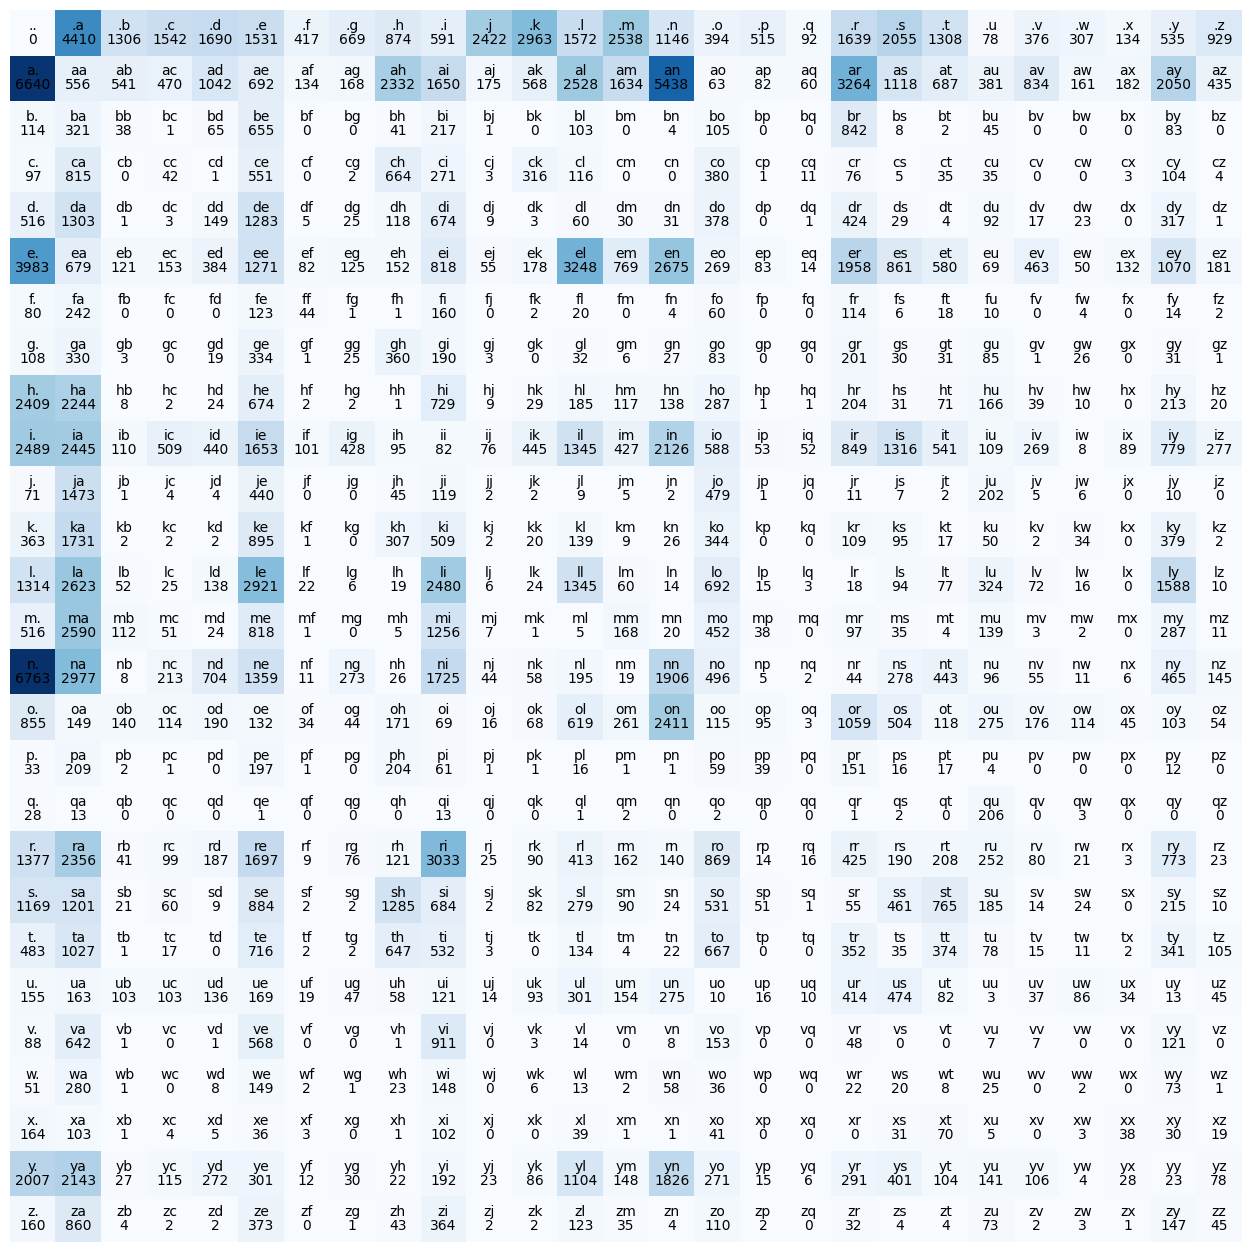

In [10]:
def plot_bigram_model(N: torch.Tensor):
    plt.figure(figsize=(16,16))
    plt.imshow(N, cmap='Blues')
    for i in range(len(vocab)):
        for j in range(len(vocab)):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color='black')
            plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black')
    plt.axis('off')
plot_bigram_model(N)

In [11]:
base_count = 1  # smooths the probabilities
P = (N+base_count).float()
P = P / P.sum(axis=1, keepdim=True)

### Sampling from the model

In [12]:
n_samples = 20
g = torch.Generator().manual_seed(2147483647)
for _ in range(n_samples):
    ix = stoi[SEP_TOK]
    out = []
    while True:
        prob_distr = P[ix]
        ix = torch.multinomial(prob_distr, num_samples=1, replacement=True, generator=g).item()
        if ix == stoi[SEP_TOK]:
            break
        out.append(itos[ix])
    print(''.join(out))

junide
janasah
p
cony
a
nn
kohin
tolian
juee
ksahnaauranilevias
dedainrwieta
ssonielylarte
faveumerifontume
phynslenaruani
core
yaenon
ka
jabdinerimikimaynin
anaasn
ssorionsush


### Evaluating the performance

In [13]:
log_likelihood = 0.0
n = 0
for word in tqdm(words, 'Evaluating'):
    chars = [SEP_TOK] + list(word) + [SEP_TOK]
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

Evaluating:   0%|          | 0/32033 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 32033/32033 [00:11<00:00, 2687.10it/s]

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
nll/n=tensor(2.4541)


## Bigram model as neural net 

In [23]:
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        chars = [SEP_TOK] + list(word) + [SEP_TOK]
        ixs = [stoi[ch] for ch in chars]
        xs.extend(ixs[:-1])
        ys.extend(ixs[1:])
    return torch.tensor(xs), torch.tensor(ys)

In [24]:
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

random.shuffle(words)
xs_train, ys_train = build_dataset(words[:n1])
xs_val, ys_val = build_dataset(words[n1:n2])
xs_test, ys_test = build_dataset(words[n2:])

xs, ys = build_dataset(words)

print(f'Number of training examples: {xs_train.shape[0]}')
print(f'Number of validation examples: {xs_val.shape[0]}')
print(f'Number of test examples: {xs_test.shape[0]}')

Number of training examples: 182500
Number of validation examples: 22815
Number of test examples: 22831


### Training loop

In [25]:
def calc_loss(xs, ys, W):
    xenc = F.one_hot(xs, num_classes=len(vocab)).float()
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    # loss = average negative log likelihood
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    return loss

In [26]:
# initializing the "model"
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(vocab), len(vocab)), generator=g, requires_grad=True)

In [27]:
lr = 75  # - 25*ep/200
for ep in range(200):
    tr_loss = calc_loss(xs_train, ys_train, W)   # + 0.01*(W**2).mean()
    
    # backward pass
    W.grad = None
    tr_loss.backward()

    # update
    W.data += -lr * W.grad

    if ep % 10 == 9:
        tr_loss = calc_loss(xs_train, ys_train, W).item()
        val_loss = calc_loss(xs_val, ys_val, W).item()
        test_loss = calc_loss(xs_test, ys_test, W).item() 
        print(f'{ep+1:>3}th epoch, {tr_loss=:.3f}; {val_loss=:.3f}; {test_loss=:.3f}')

 10th epoch, tr_loss=2.612; val_loss=2.614; test_loss=2.619
 20th epoch, tr_loss=2.529; val_loss=2.531; test_loss=2.536
 30th epoch, tr_loss=2.501; val_loss=2.503; test_loss=2.508
 40th epoch, tr_loss=2.488; val_loss=2.489; test_loss=2.495
 50th epoch, tr_loss=2.480; val_loss=2.482; test_loss=2.487
 60th epoch, tr_loss=2.475; val_loss=2.476; test_loss=2.482
 70th epoch, tr_loss=2.472; val_loss=2.473; test_loss=2.479
 80th epoch, tr_loss=2.469; val_loss=2.470; test_loss=2.476
 90th epoch, tr_loss=2.467; val_loss=2.468; test_loss=2.474
100th epoch, tr_loss=2.466; val_loss=2.467; test_loss=2.473
110th epoch, tr_loss=2.465; val_loss=2.466; test_loss=2.471
120th epoch, tr_loss=2.464; val_loss=2.465; test_loss=2.470
130th epoch, tr_loss=2.463; val_loss=2.464; test_loss=2.470
140th epoch, tr_loss=2.462; val_loss=2.463; test_loss=2.469
150th epoch, tr_loss=2.462; val_loss=2.462; test_loss=2.468
160th epoch, tr_loss=2.461; val_loss=2.462; test_loss=2.468
170th epoch, tr_loss=2.461; val_loss=2.4

### Sampling from the network

In [28]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    ix = stoi[SEP_TOK]
    out = []
    while True:
        # forward pass
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(vocab)).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)

        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        if ix == stoi[SEP_TOK]:
            break
        out.append(itos[ix])
    print(''.join(out))

junide
janasah
prelay
a
nn
kohin
tolia
s
tee
ksahnaauranilevias
dedainrwieta
ssonielylarte
faveumerifontume
phynslenaruani
core
yaenon
ka
jabi
werimikimaynin
anaasn


### Checking if model learned the counts/probs
and it surely did :D. It is clear after normalizing the rows (displaying probs instead of counts)

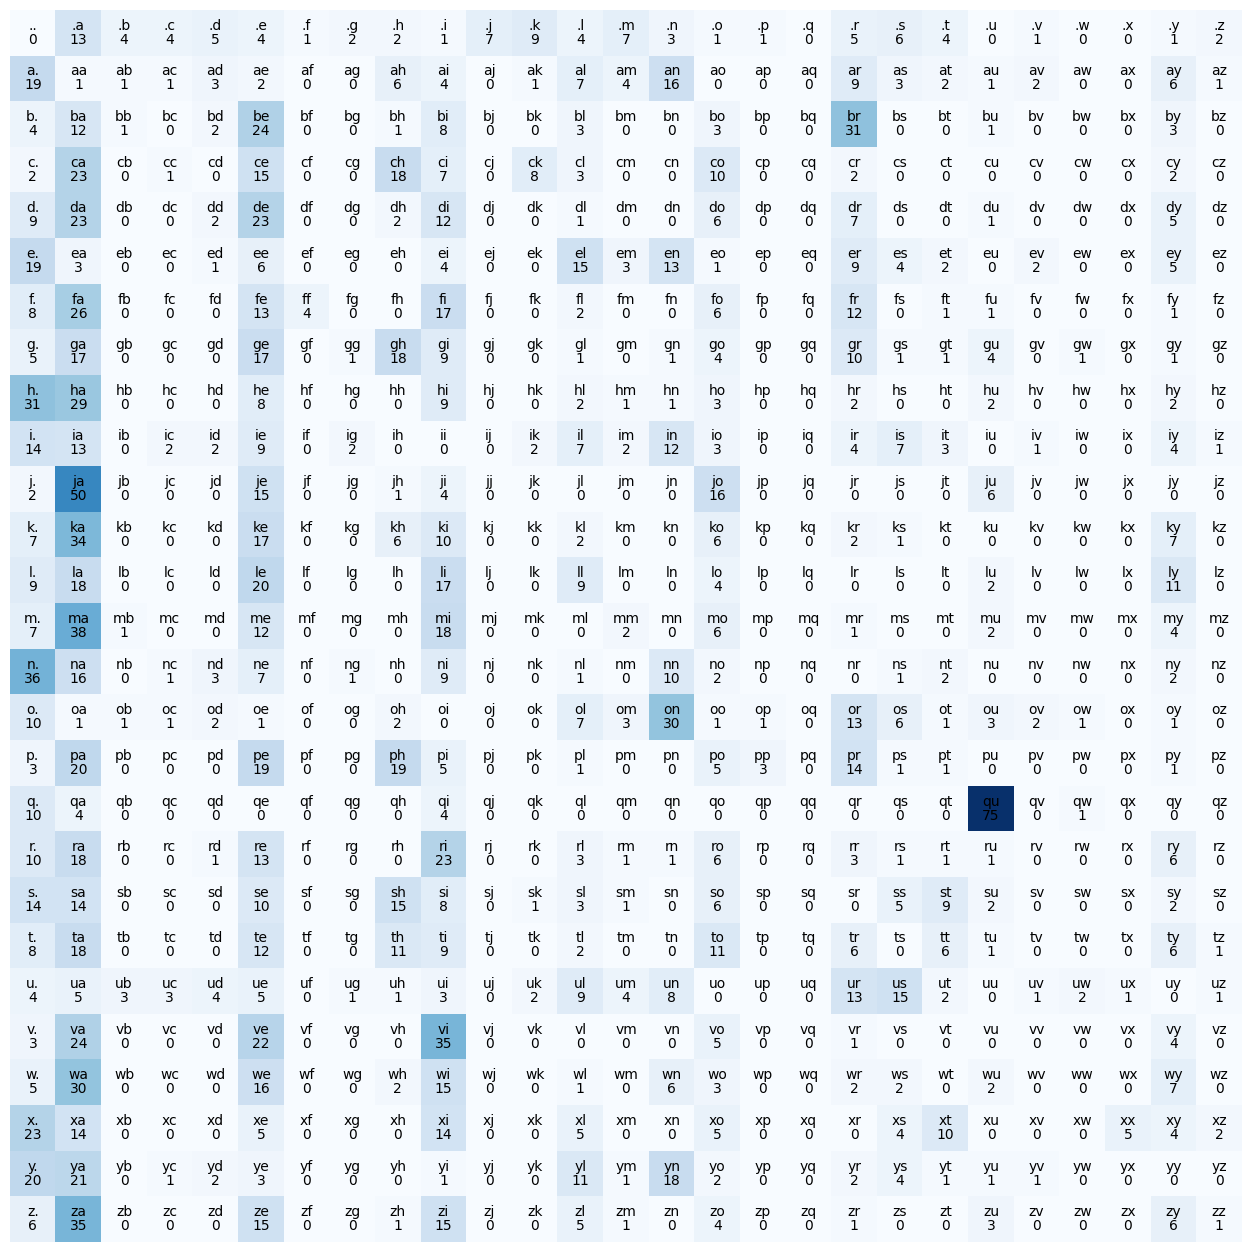

In [29]:
# floats take to much space - multiply probs by 100 and convert to int 
plot_bigram_model((P*100).int())

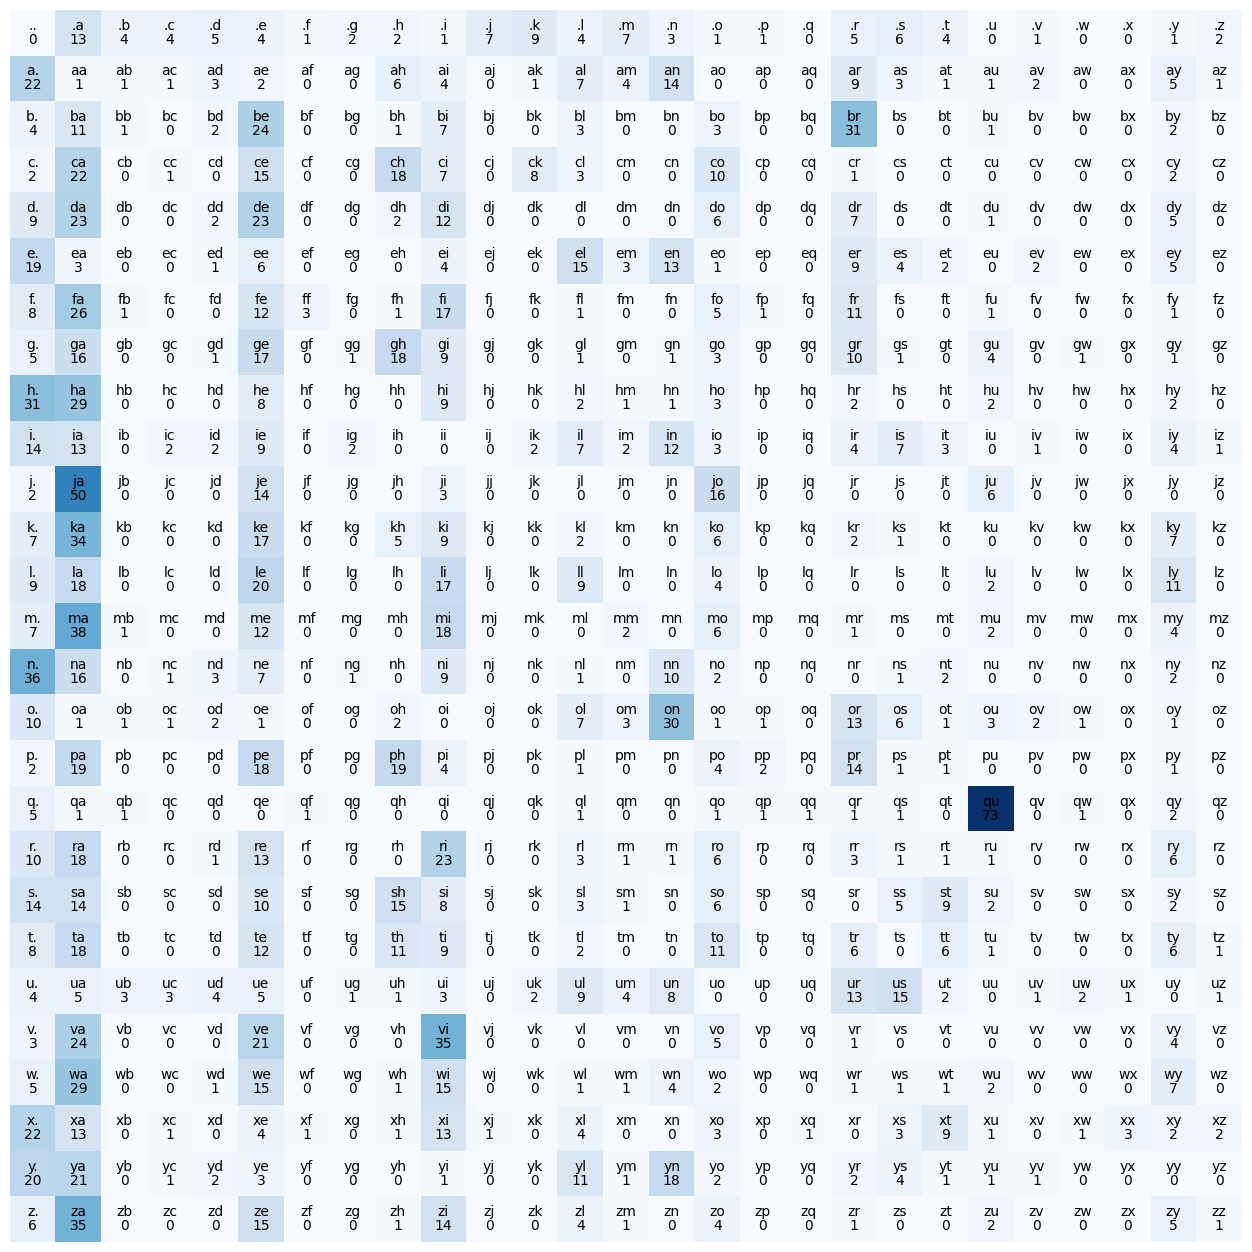

In [30]:
P_from_weights = W.exp() / W.exp().sum(1, keepdim=True)
plot_bigram_model((P_from_weights * 100).int())